# Librairies

In [1]:
import pandas as pd 
import geopandas as gpd
import matplotlib.pylab as plt
import contextily as cx
import numpy as np

# Load data

## Sensors location

In [2]:
# Sensors location
gdf = gpd.read_file('raw/DAUERZAEHLOGD/DAUERZAEHLOGDPoint.shp')

(16.171703338623043, 16.611286443301715, 48.10753872973258, 48.34176027341417)

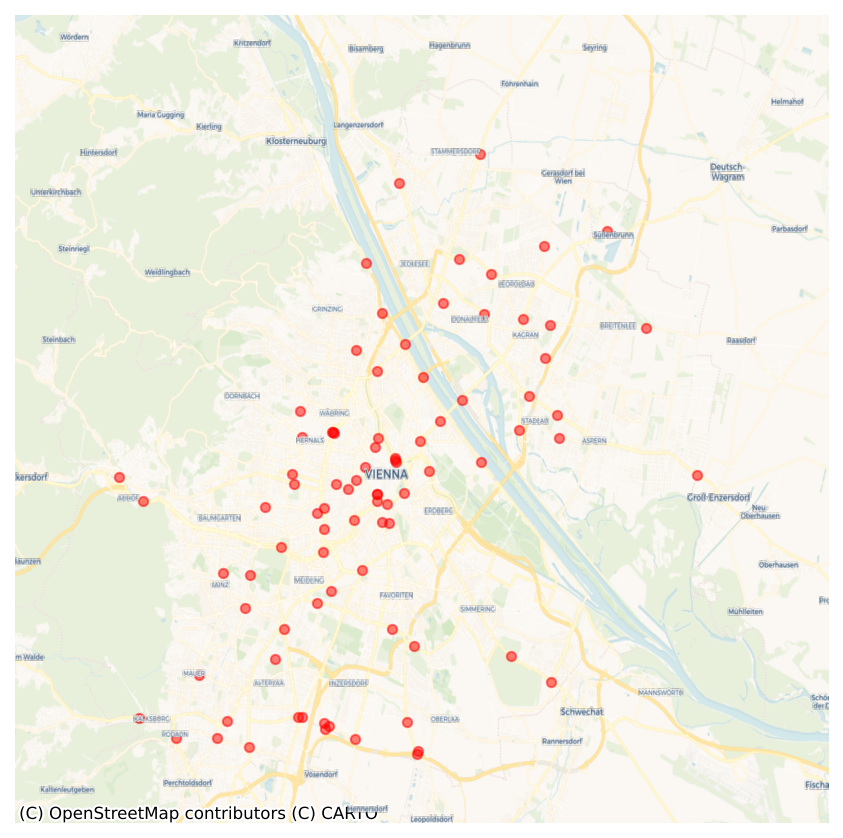

In [3]:
# Plot sensors

fig, ax = plt.subplots(dpi = 150, figsize = (7,7))

gdf.plot(ax=ax, color = 'r', markersize = 20, alpha = .5, )
# Add context in backround
cx.add_basemap(ax, crs = gdf.crs, source=cx.providers.CartoDB.VoyagerNoLabels)

cx.add_basemap(ax, crs = gdf.crs, source=cx.providers.CartoDB.VoyagerOnlyLabels)

# Remove lat lon
plt.axis('off')
plt.axis('auto')

In [4]:
gdf.columns

Index(['OBJECTID', 'ZST_ID', 'ZST_NAME', 'STR_NR', 'BETRIEBNAH', 'RICHTUNG_1',
       'RICHTUNG_2', 'LAGE', 'GERAETEART', 'GERAETEAR0', 'geometry'],
      dtype='object')

## Traffic counts

In [5]:
df = pd.read_csv('raw/dauerzaehlstellen.csv', delimiter=';', encoding='latin-1')

In [6]:
df.columns

Index(['JAHR', 'MONAT', 'ZNR', 'ZNAME', 'STRTYP', 'STRNR', 'RINAME', 'FZTYP',
       'DTVMS', 'DTVMF', 'DTVMO', 'DTVDD', 'DTVFR', 'DTVSA', 'DTVSF', 'TVMAX',
       'TVMAXT'],
      dtype='object')

## Map matching with OSM

In [7]:
# This should be done with gdf prior to join

import sys
from pathlib import Path

# Add the ../assets directory to sys.path
sys.path.append(str(Path("../../assets").resolve()))

from map_matching_OSM import points_matching

In [8]:
gdf.rename(columns = {'ZST_NAME':'raw_name'}, inplace=True)

In [9]:
gdf = points_matching(gdf)

City downloaded


 37%|███▋      | 32/87 [00:00<00:00, 96.37it/s] 

Value Error - No roads found nearby current index


 72%|███████▏  | 63/87 [00:00<00:00, 98.07it/s]

Value Error - No roads found nearby current index


100%|██████████| 87/87 [00:00<00:00, 97.89it/s] 

Value Error - No roads found nearby current index
We failed to match 3 sensors
...on a total of 87 sensors


In [10]:
gdf[['raw_name', 'osm_name', 'osm_distance', 'osm_lanes', 'osm_maxspeed']][:20].drop_duplicates()

,raw_name,osm_name,osm_distance,osm_lanes,osm_maxspeed
0,Prager Straße,Prager Straße,2.049374,NaN,30.0
1,Vorarlberger Allee Ost,Vorarlberger Allee,0.193899,NaN,50.0
2,Spange Vösendorf,Vösendorfer Nordspange,1.030767,2.0,50.0
3,Altmannsdorfer Straße II,Altmannsdorfer Straße,3.972342,2.0,50.0
4,Vorarlberger Allee West,Vorarlberger Allee,2.659414,2.0,50.0
5,Linke Wienzeile,Linke Wienzeile,8.770350,4.0,50.0
6,Liesingbach,Karl-Heinz-Straße,14.381343,NaN,30.0
7,Operngasse,Operngasse,11.176328,3.0,50.0
8,Seyringer Straße,Seyringer Straße,3.254582,2.0,50.0
9,Margaretengürtel,Unterfahrung Matzleinsdorfer Platz,3.684086,2.0,50.0


# Treatment

In [11]:
column_names = [
    "JAHR",         # Year of the count
    "MONAT",        # Month of the count
    "ZNR",          # Count location number (linkable to ZST_ID from "Traffic Count Locations - Sites")
    "ZNAME",        # Count location name
    "STRTYP",       # Street type (B = Main Road B, G = Municipal Road)
    "STRNR",        # Street number (designation of Main Road B network)
    "RINAME",       # Direction name (destination)
    "FZTYP",        # Vehicle type/group (Kfz = All motor vehicles, LkwÄ = Truck-like motor vehicles)
   # "DTV",          # Average daily traffic (number of vehicles for the specified FZTYP over 24h)
    "DTVMS",        # Average daily traffic (Monday to Sunday, all days)
    "DTVMF",        # Average daily traffic (Monday to Friday, excluding holidays)
    "DTVMO",        # Average daily traffic (Monday, excluding holidays)
    "DTVDD",        # Average daily traffic (Tuesday to Thursday, excluding holidays)
    "DTVFR",        # Average daily traffic (Friday, excluding holidays)
    "DTVSA",        # Average daily traffic (Saturday, excluding holidays)
    "DTVSF",        # Average daily traffic (Sunday and holidays)
    "TVMAX",        # Maximum daily traffic (all days)
    "TVMAXT",       # Day and date of maximum traffic (TVMAX); '*' indicates estimated values
  #  "NEG_VALUES",   # Negative values (-29): denote unavailable data (e.g., outages or opposing direction in one-way streets)
]

new_column_names = [
    "Year",         # Year of the count
    "Month",        # Month of the count
    "ZNR",          # Count location number (linkable to ZST_ID from "Traffic Count Locations - Sites")
    "ZNAME",        # Count location name
    "Street_type",       # Street type (B = Main Road B, G = Municipal Road)
    "Street_number",        # Street number (designation of Main Road B network)
    "Direction",       # Direction name (destination)
    "Vehicle_type",        # Vehicle type/group (Kfz = All motor vehicles, LkwÄ = Truck-like motor vehicles)
    "AADT",        # Average daily traffic (Monday to Sunday, all days)
    "AAWT",        # Average daily traffic (Monday to Friday, excluding holidays)
    "DTVMO",        # Average daily traffic (Monday, excluding holidays)
    "DTVDD",        # Average daily traffic (Tuesday to Thursday, excluding holidays)
    "DTVFR",        # Average daily traffic (Friday, excluding holidays)
    "DTVSA",        # Average daily traffic (Saturday, excluding holidays)
    "DTVSF",        # Average daily traffic (Sunday and holidays)
    "TVMAX",        # Maximum daily traffic (all days)
    "TVMAXT",       # Day and date of maximum traffic (TVMAX); '*' indicates estimated values
]

In [12]:
# Remove negative values (unavailable data)
df = df[df.DTVMS >= 0]

In [13]:
df.columns = new_column_names
df = df[['Year', 'Month', 'ZNR', 'ZNAME', 'Street_type', 'Street_number', 'Direction', 'Vehicle_type', 'AADT', 'AAWT']]

In [14]:
df.shape

(36962, 10)

In [15]:
11730*3

35190

In [16]:
df.Direction.value_counts()

Direction
Gesamt                  11730
Zentrum                  5596
Wienzeile                 792
S1                        792
Kagran                    786
                        ...  
Schottenring              126
Gürtelbrücke              108
Floridsdorfer Brücke      108
Reichsbrücke              108
Lerchenfelder Gürtel       30
Name: count, Length: 87, dtype: int64

In [17]:
df.Direction.isna().sum()

0

In [18]:
df[df.ZNR == 1075].Direction.unique()

array(['Leopoldstadt', 'Donaustadt', 'Gesamt'], dtype=object)

In [19]:
# For the direction, "Gesamt" means both
# For the same ZNR we sometime have directed measurements and Both
# In the case where the "both" measure is not given, we keep the records 
c = 0
l_df = []
for code in df.ZNR.unique():
    for year in df[df.ZNR == code].Year.unique():
        if 'Gesamt' not in df[(df.ZNR == code) & (df.Year == year)].Direction.values:
            #print(code, year)
            c+=1
            l_df.append(df[(df.ZNR == code) & (df.Year == year)])
df_directed = pd.concat(l_df)
c

82

In [20]:
df = pd.concat(
    [df[df.Direction == 'Gesamt'], df_directed]
)

In [21]:
# For the direction, "Gesamt" means both
df['raw_oneway'] = df.Direction.apply(lambda x : True if x != 'Gesamt' else False)
df['raw_direction'] = df.Direction.apply(lambda x : x if x != 'Gesamt' else np.nan)

In [22]:
# # For the direction, "Gesamt" means both
# # Since the geometries are in the middle of the roads, we'll use that

# df = df[df.Direction == 'Gesamt']

In [23]:
# Aggregated monthly values
df = df.groupby(['Year',  'ZNR', 'Vehicle_type']).agg(
    AADT = ('AADT', 'mean'),
    AAWT = ('AAWT', 'mean'),
    Street_name = ('ZNAME', lambda x : x.iloc[0]),
    raw_oneway = ('raw_oneway', lambda x : x.iloc[0]),
    raw_direction = ('raw_direction', lambda x : x.iloc[0])
)

In [24]:
df = df.unstack(level = 2)

In [25]:
# Remove multindexing columns
df.columns = ["_".join(col).strip() for col in df.columns.values]

In [26]:
# (Kfz = All motor vehicles, LkwÄ = Truck-like motor vehicles)
df.rename(columns = {
    'AADT_Kfz':'AADT',
    'AADT_LkwÄ':'TR_AADT',
    'AAWT_Kfz':'AAWT',
    'AAWT_LkwÄ':'TR_AAWT',
    'Street_name_Kfz':'Street_name',
    'raw_oneway_Kfz':'raw_oneway',
    'raw_direction_Kfz':'raw_direction'
},  inplace=True)

In [27]:
df = df.drop(['Street_name_LkwÄ', 'raw_direction_LkwÄ', 'raw_oneway_LkwÄ'], axis = 1).join(
    gdf.rename(columns = {'ZST_ID':'ZNR'}).set_index('ZNR')[[ 'raw_name', 'geometry', 'osm_name', 'osm_type', 'osm_distance', 'osm_lanes', 'osm_oneway', 'osm_maxspeed', 'osmid' ]],
    on = 'ZNR',
    how = 'inner',
    rsuffix='_ref'
)

df = gpd.GeoDataFrame(df,
                      geometry = 'geometry',
                      crs = 'epsg:4326')

In [28]:
df[df.Street_name != df.raw_name][['Street_name', 'raw_name']].drop_duplicates()

Street_name                            raw_name
Year ZNR                                                                
2016 1089            Floridsdorf-Br.                Floridsdorfer Brücke
     1170          Donaukanal Straße  Obere Donaustraße/Franz-Josefs-Kai
     1182        Simmeringer Hptstr.             Simmeringer Hauptstraße
     1190           Angyalföldstraße                    Angyalföldsrtaße
     1196        Erzherzog-Karl-Str.               Erzherzog-Karl-Straße
     1211      Laxenburger Straße II                  Laxenburger Straße
     1607            Weißgerberlände                    Weißgerber Lände
     1608  Margaretengürtel/Matzl.Pl                    Margaretengürtel
     1611   Simmeringer Hauptstr. II             Simmeringer Hauptstraße
     1614               Maxingstraße                         Maxinggasse
     1621           Währinger Gürtel           Währinger Gürtel Nord/Süd
     1622        Himberger Straße II                   Himberger Str. II
2018 1625            Favoritenstraße                    Taubstummengasse
     1626    Ludwig-van-Höhnel-Gasse             Ludwig-von-Höhnel-Gasse
2019 1224           Wagramer Str. II                  Wagramer Straße II

In [29]:
for year in range(2016, 2024):
    print(year, df.loc[year].geometry.unique().size == df.loc[year].shape[0])

2016 True
2017 True
2018 True
2019 True
2020 True
2021 True
2022 True
2023 True


In [30]:
df.drop('Street_name', axis = 1, inplace = True)

In [31]:
df.osm_maxspeed.isna().sum() / df.shape[0]

0.07003257328990228

In [32]:
from validate_dataset import validate_dataset

In [33]:
df = validate_dataset(df)

Number of NaN values for AADT: 0
Number of NaN values for geometry: 0
Number of <=1 values for AADT: 0
Number of >1e5 values for AADT: 0


# Final Saving

In [34]:
for year in range(2016, 2025):
    df.loc[year].to_file(f'treated/Vienna_AADT_AAWT_{year}.geojson', index = False)